In [1]:
# Load in graphs and only retain the neighborhood around the interactions between protein and ligand atoms

%matplotlib inline

import networkx as nx
from Bio.PDB import *
from eden.util import read
#from GArDen.interfaces import convert, transform


# !! all values need to be verified (I just found them in a single spreadsheet in the web)

aa_properties_dict = { "fullname" : { "G":"glycine","A":"alanine" ,"V":"valine","I":"isoleucine" ,"L":"leucine" ,
                                      "M":"methionine" ,"F":"phenylalanine" ,"Y":"tyrosine" ,"W":"tryptophan" ,"S":"serine" ,
                                      "T":"threonine" ,"N":"asparagine" ,"Q":"glutamine" ,"K":"lysine" ,"R":"arginine" ,
                                      "H":"histidine" ,"D":"aspartic acid" ,"E":"glutamic acid" ,"C":"cytosine" ,"P":"proline" },
                       "oneLetterCode" : { "Gly":"G", "Ala":"A", "Val":"V" ,"Ile":"I", "Leu":"L", "Met":"M", "Phe":"F", "Tyr":"Y", "Trp":"W", "Ser":"S" ,
                                           "Thr":"T" ,"Asn":"N" ,"Gln":"Q" ,"Lys":"K" , "Arg":"R" ,"His":"H" ,"Asp":"D", "Glu":"E" ,"Cys":"C" ,"Pro":"P" },
                       "threeLetterCode" : { "G":"Gly" ,"A":"Ala" ,"V":"Val" ,"I":"Ile" ,"L":"Leu" ,"M":"Met" ,"F":"Phe" ,"Y":"Tyr" ,"W":"Trp" ,"S":"Ser" ,
                                             "T":"Thr" ,"N":"Asn" ,"Q":"Gln" ,"K":"Lys" ,"R":"Arg" ,"H":"His" ,"D":"Asp" ,"E":"Glu" ,"C":"Cys" ,"P":"Pro" },
                       "residue_class" : { "G":"aliphatic" ,"A":"aliphatic" ,"V":"aliphatic" ,"I":"aliphatic" ,"L":"aliphatic" ,"M":"thioether" ,"F":"aromatic",
                                           "Y":"aromatic" ,"W":"aromatic" ,"S":"alcohol" , "T":"alcohol" ,
                                           "N":"amide" ,"Q":"amide" ,"K":"amine" ,"R":"amine" ,"H":"amine" ,"D":"carboxylic acid" ,"E":"carbxylic acid" ,"C":"thiol" ,"P":"cyclic aliphatic" },
                       "polarity" : { "G":0 ,"A":0 ,"V":0 ,"I":0 ,"L":0 ,"M":0 ,"F":0 ,"Y":1 ,"W":0 ,"S":1,
                                      "T":1 ,"N":1 ,"Q":1 ,"K":1 ,"R":1 ,"H":1 ,"D":1 ,"E":1 ,"C":1 ,"P":0 },
                       "charge" : { "G":0 ,"A":0 ,"V":0 ,"I":0 ,"L":0 ,"M":0 ,"F":0 ,"Y":0 ,"W":0 ,"S":0 ,
                                      "T":0 ,"N":1 ,"Q":0 ,"K":1 ,"R":1 ,"H":1 ,"D":-1 ,"E":-1 ,"C":0 ,"P":0 },
                       # hydrophobicity after Hoop and Woods
                       "hydrophobicity_Hoop" : { "G":0 ,"A":-0.5 ,"V":-1.5 ,"I":-1.8 ,"L":-1.8 ,"M":-1.3 ,"F":-2.5 ,"Y":-2.3 ,"W":-3.4 ,"S":0.3 ,
                                      "T":-0.4 ,"N":0.2 ,"Q":0.2 ,"K":3.0 ,"R":3.0 ,"H":-0.5 ,"D":3.0 ,"E":3.0 ,"C":-1.0 ,"P":0.0 },
                       # hydrophobicity after Kyle and Doolittle
                       "hydrophobicity_Kyle" : { "G":-0.4 ,"A":1.8 ,"V":4.2 ,"I":4.5 ,"L":3.8 ,"M":4.5 ,"F":2.8 ,"Y":-1.3 ,"W":-0.9 ,"S":-0.8 ,
                                      "T":-0.7 ,"N":-3.5 ,"Q":-3.5 ,"K":-3.9 ,"R":-4.5 ,"H":-3.2 ,"D":-3.5 ,"E":-3.5 ,"C":2.5 ,"P":-1.6 },
                       # hydrophobicity after Engelmann
                       "hydrophobicity_Engelmann" : { "G":1 ,"A":1.6 ,"V":2.6 ,"I":3.1, "L":2.8 ,"M":3.4 ,"F":3.7 ,"Y":-0.7 ,"W":1.9 ,"S":0.6 ,
                                      "T":1.2 ,"N":-4.8 ,"Q":-4.1 ,"K":-8.8 ,"R":-12.3 ,"H":-3.0 ,"D":-9.2 ,"E":-8.2 ,"C":2.0 ,"P":-0.2 },
                       # residue surface in square AAngstroem
                       "surface_area" : { "G":75.0 ,"A":115.0 ,"V":155.0 ,"I":175.0 ,"L":170.0 ,"M":185.0 ,"F":210.0 ,"Y":230.0 ,"W":255.0 ,"S":115.0 ,
                                      "T":140.0 ,"N":150.0 ,"Q":190.0 ,"K":200.0 ,"R":225.0 ,"H":195.0 ,"D":160 ,"E":180 ,"C":135.0 ,"P":145.0 },
                       # residue volume in cubic AAngstroem
                       "volume" : { "G":60.1 ,"A":88.6 ,"V":140.0 ,"I":166.7 ,"L":166.7 ,"M":162.9 ,"F":189.9 ,"Y":193.3 ,"W":227.8 ,"S":89.0 ,
                                      "T":116.1 ,"N":111.1 ,"Q":138.4 ,"K":168.6 ,"R":173.4 ,"H":153.2 ,"D":114.1 ,"E":143.8 ,"C":108.5 ,"P":112.7 }
                     }

# reduced amino acid codes from L. R. Murphy, A. Wallqvist, and R. M. Levy, “Simplified amino acid alphabets for protein fold recognition and implications for folding,” Protein Eng., vol. 13, no. 3, pp. 149–152, Mar. 2000.

red_code_3 = ['LASGVTIPMC', 'EKRDNQH', 'FYW']

red_code_5 = ['LVIMC', 'ASGTP', 'FYW', 'EDNQ', 'KRH']

red_code_6 = ['LVIM', 'ASGT', 'PHC', 'FYW', 'EDNQ', 'KR']

red_code_12 = ['LVIM', 'C', 'A', 'G', 'ST', 'P', 'FY', 'W', 'EQ', 'DN', 'KR', 'H']


ac_dict = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
           'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
           'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
           'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
# codes from L. R. Murphy, A. Wallqvist, and R. M. Levy, “Simplified amino acid alphabets for protein fold recognition and implications for folding,” Protein Eng., vol. 13, no. 3, pp. 149–152, Mar. 2000.
code_3 = ['LASGVTIPMC', 'EKRDNQH', 'FYW']
code_5 = ['LVIMC', 'ASGTP', 'FYW', 'EDNQ', 'KRH']
code_6 = ['LVIM', 'ASGT', 'PHC', 'FYW', 'EDNQ', 'KR']
code_12 = ['LVIM', 'C', 'A', 'G', 'ST', 'P', 'FY', 'W', 'EQ', 'DN', 'KR', 'H']

In [2]:
def get_atom_id(atom, ligand_id):
    id = atom.get_id() + '_' + str(ligand_id)
    return str(id)

def get_atom_label(atom):
    label = atom.element
    return str(label)

def add_ligand_graph(graph, structure=None, atoms=None, ligand_id=None):
    sb_HH = 0.74
    sb_CH = 1.09
    sb_CC = 1.53
    db_CC = 1.32
    tb_CC = 1.18
    
    sb_NH = 1.01
    sb_NC = 1.47
    db_NC = 1.28
    tb_NC = 1.14
    
    sb_NN = 1.45
    db_NN = 1.25
    tb_NN = 1.1
    
    sb_OH = 0.96
    
    sb_OC = 1.43
    db_OC = 1.21
    tb_OC = 1.13
    
    sb_ON = 1.4
    db_ON = 1.21
    
    sb_OO = 1.48
    db_OO = 1.21
    
    triple_bond_threshold = 1.18
    double_bond_threshold = 1.32
    single_bond_threshold = 1.8

    # add nodes
    for atom in atoms:
        i = get_atom_id(atom, ligand_id)  
        label = get_atom_label(atom)
        graph.add_node(i, 
                       label=label, 
                       chain_id=ligand_id,
                       typeof='ligand')

    # add edges
    for n, atom1 in enumerate(atoms):
        i = get_atom_id(atom1, ligand_id)
        for atom2 in atoms[n:]:
            j = get_atom_id(atom2, ligand_id)
            atom_distance = atom2 - atom1
            bond_type=None
            if( atom_distance < triple_bond_threshold):
                bond_type='3'
            elif( atom_distance < double_bond_threshold):
                bond_type='2'
            elif( atom_distance < single_bond_threshold):
                bond_type='1'
            else:
                bond_type=None
            if bond_type:
                graph.add_edge(i,j, bond_type=bond_type)

def extract_residues(structure):
    res_seq = []
    for model in structure:
        for chain_id, chain in enumerate(model):
            for res in chain:
                atoms = [atom for atom in res if atom.get_name()=='CA']
                if atoms:
                    ca_atom = atoms[0]
                    res_id = get_residue_id(res, chain_id)
                    res_seq.append((res_id, res.get_resname(), ca_atom, chain_id))
    return res_seq

def ac_encoding(code, scheme='code_20'):

    
    if ac_dict.get(code,False) is False:
        return code
    ac_1letter_code = ac_dict[code]
    if scheme=='code_20':
        return ac_1letter_code
    elif scheme=='code_3':
        for n,codes in  enumerate(code_3):
            if ac_1letter_code in codes: return n
    elif scheme=='code_5':
        for n,codes in  enumerate(code_5):
            if ac_1letter_code in codes: return n
    elif scheme=='code_6':
        for n,codes in  enumerate(code_6):
            if ac_1letter_code in codes: return n
    elif scheme=='code_12':
        for n,codes in  enumerate(code_12):
            if ac_1letter_code in codes: return n
    else:
        raise Exception('Unknown scheme: %s'%scheme)

        
def make_dark_edges(g, distance_threshold2=4):
    for u in g.nodes():
        neighs = g.neighbors(u)
        for v in neighs:
            if g.edge[u][v]['len'] > distance_threshold2:
                g.edge[u][v]['nesting']=True

def is_valid_residue(residue):
    res_tuple = residue.get_full_id()
    res_name = res_tuple[3]
    if ' ' in res_name[0]:
        return True
    else:
        return False
    
def get_residue_id(residue, chain_id):
    res_tuple = residue.get_full_id()
    res_name = res_tuple[3]
    res_id = res_name[1] 
    res_id = str(res_id) + '_' + str(chain_id)
    return res_id

def select_ligands(structure, ligand_marker):
    for model in structure:
        for chain_id, chain in enumerate(model):
            for res in chain:
                if res.get_resname() == ligand_marker:
                    atoms = Selection.unfold_entities(res, 'A')
                    yield atoms
            
def add_ligands(graph, structure, ligand_marker, ligand_distance_threshold = 5.4):
    atoms_list = select_ligands(structure, ligand_marker=ligand_marker)
    atoms_list = list(atoms_list)
    
    for ligand_chain_id, atoms in enumerate(atoms_list):
        add_ligand_graph(graph, structure, atoms, ligand_chain_id)
        
        models = structure.get_list()
        #iterate over the models
        for aModel in models:
            #get all the chains in this model
            chains = aModel.get_list()
            #get all the atoms in this model
            model_atoms = Selection.unfold_entities(aModel,'A')
            #create a NeighborSearch
            ns = NeighborSearch(model_atoms)
            #search the chains in for the ligand_id            
            for chain_id, aChain in enumerate(chains): 
                if ligand_chain_id == chain_id:
                    for atom in atoms:
                        atom_id = get_atom_id(atom, chain_id)
                        neighbors = ns.search(atom.get_coord(), ligand_distance_threshold)
                        residue_list = Selection.unfold_entities(neighbors, 'R')
                        for aResidue in residue_list:
                            if is_valid_residue(aResidue):
                                res_id = get_residue_id(aResidue, chain_id)
                                graph.add_edge(atom_id, res_id, label='=', nesting=True)
                                graph.node[res_id]['contact']=True
        
    
def make_graph(id, target, structure, ligand_marker, distance_threshold=5, distance_threshold2=4, scheme='code_20', 
               ligand_distance_threshold = 5.4):
    res_seq = extract_residues(structure)

    g = nx.Graph()
    g.graph['id'] = id
    g.graph['target'] = float(target)
    for res_id, ac,atom, chain_id in res_seq:
        if ac in ac_dict: # LS: added this constraint, otherwise key error for 2R58 and MLY
            ac1code = ac_dict[ac]
            g.add_node(res_id, 
                   label=ac_encoding(ac, scheme=scheme), 
                   typeof='residue',
                   name=ac1code, 
                   chain_id=chain_id,
                   charge=aa_properties_dict['charge'][ac1code],
                   polarity=aa_properties_dict['polarity'][ac1code],
                   atom=atom, 
                   contact=False,
                   coords=atom.get_coord())

    for u in g.nodes():
        for v in g.nodes():
            dist = g.node[u]['atom'] - g.node[v]['atom']
            if 0 < dist < distance_threshold:
                g.add_edge(u,v, label='-', len=dist)
    make_dark_edges(g, distance_threshold2=distance_threshold2)
    # put for loop for multiple ligands
    add_ligands(g, structure,  ligand_marker, ligand_distance_threshold)
    return g

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict, deque
class MarkActive(BaseEstimator, TransformerMixin):

    """
    Missing.
    """

    def __init__(self, max_depth=10, attribute='active', key_nesting='nesting'):
        self.max_depth = max_depth
        self.attribute = attribute
        self.key_nesting = key_nesting

    def fit(self):
        return self

    def transform(self, graphs):
        """
        Todo.
        """
        try:
            for graph in graphs:
                marked_graph = self.mark_active(graph)
                yield marked_graph
        except Exception as e:
            logger.debug('Failed iteration. Reason: %s' % e)
            logger.debug('Exception', exc_info=True)

    def mark_active(self, graph):
        for u,v in graph.edges():
            # iterate over edges and select edges that are of the nesting type
            if graph.edge[u][v].get(self.key_nesting,False):
                # select the smallest id node as root for marking
                if u < v:
                    root=u
                else:
                    root=v
                self.mark_single_vertex_breadth_first_visit(graph, root=root)
        return graph
            
    def mark_single_vertex_breadth_first_visit(self, graph, root=None):
        visited = set()  # use a set as we can end up exploring few nodes
        # q is the queue containing the frontieer to be expanded in the BFV
        q = deque()
        q.append(root)
        # the map associates to each vertex id the distance from the root
        dist = {}
        dist[root] = 0
        visited.add(root)
        while len(q) > 0:
            # extract the current vertex
            u = q.popleft()
            d = dist[u] + 1
            if d <= self.max_depth:
                # iterate over the neighbors of the current vertex
                for v in graph.neighbors(u):
                    if v not in visited:
                        # skip nesting edge-nodes
                        if graph.edge[u][v].get(self.key_nesting, False) is False:
                            dist[v] = d
                            visited.add(v)
                            graph.node[v][self.attribute]=True
                            q.append(v)

In [13]:
%%time

from GArDen.interfaces import convert, transform
from GArDen.transform import DeleteNode

graphs = []
# read in PDB files and retrieve the ligand codes
for line in read('INDEX_refined_data.2015_temp'):
    if not(line.startswith('#')): # skip info lines
        parts = line.split()
        pdb_id = parts[0]
        target = parts[3]
        ligand_marker = parts[7].strip('()')
        if '-' not in ligand_marker: # TODO: figure out what to do with peptides and if there are multiple ligands
            if '&' not in ligand_marker:
                #print 'PDB:'+pdb_id+', Ligand:'+ligand
                print 'Retrieving '+pdb_id+'...'
                fname = PDBList().retrieve_pdb_file(pdb_id,pdir='pdbs') # pdir is the directory to store the PDBs
                structure = PDBParser().get_structure('X', fname) # why X?
                #g = make_graph(pdb_id, target, structure, ligand_marker, distance_threshold=8, distance_threshold2=6, scheme='code_3')
                #g = make_graph(pdb_id, target, structure, ligand_marker, distance_threshold=6, distance_threshold2=3, scheme='code_3')
                g = make_graph(pdb_id, target, structure, ligand_marker, distance_threshold=4, distance_threshold2=2, scheme='code_3')
                graphs.append(g)
                
# toy example
max_depth = 1

parameters_priors = dict(max_depth=max_depth, attribute='active')
graphs = transform(graphs, program=MarkActive(), parameters_priors=parameters_priors)
#parameters_priors = dict(attribute_value_dict=[dict(active=False, type='protein')])
parameters_priors = dict(attribute_value_dict=[dict(active=False, typeof='residue')])
graphs = transform(graphs, program=DeleteNode(), parameters_priors=parameters_priors)
#graphs = transform(graphs, program=TrimToLargestComponent())

graphs = list(graphs)



#fname = PDBList().retrieve_pdb_file('2r58')
#structure = PDBParser().get_structure('X', fname)
#g0 = make_interaction_graph(structure,'MLY')

#print extract_residues(structure)[0]
#extract_ligand_atoms(structure, 'MLY')
#th=3
#g = make_graph(structure, distance_threshold=10, distance_threshold2=th, scheme='code_6')
#draw_graph(g, **display_params)

Retrieving 2r58...
Structure exists: 'pdbs/pdb2r58.ent' 
Retrieving 3c2f...
Structure exists: 'pdbs/pdb3c2f.ent' 
Retrieving 3g2y...
Structure exists: 'pdbs/pdb3g2y.ent' 
CPU times: user 3.3 s, sys: 107 ms, total: 3.41 s
Wall time: 3.54 s


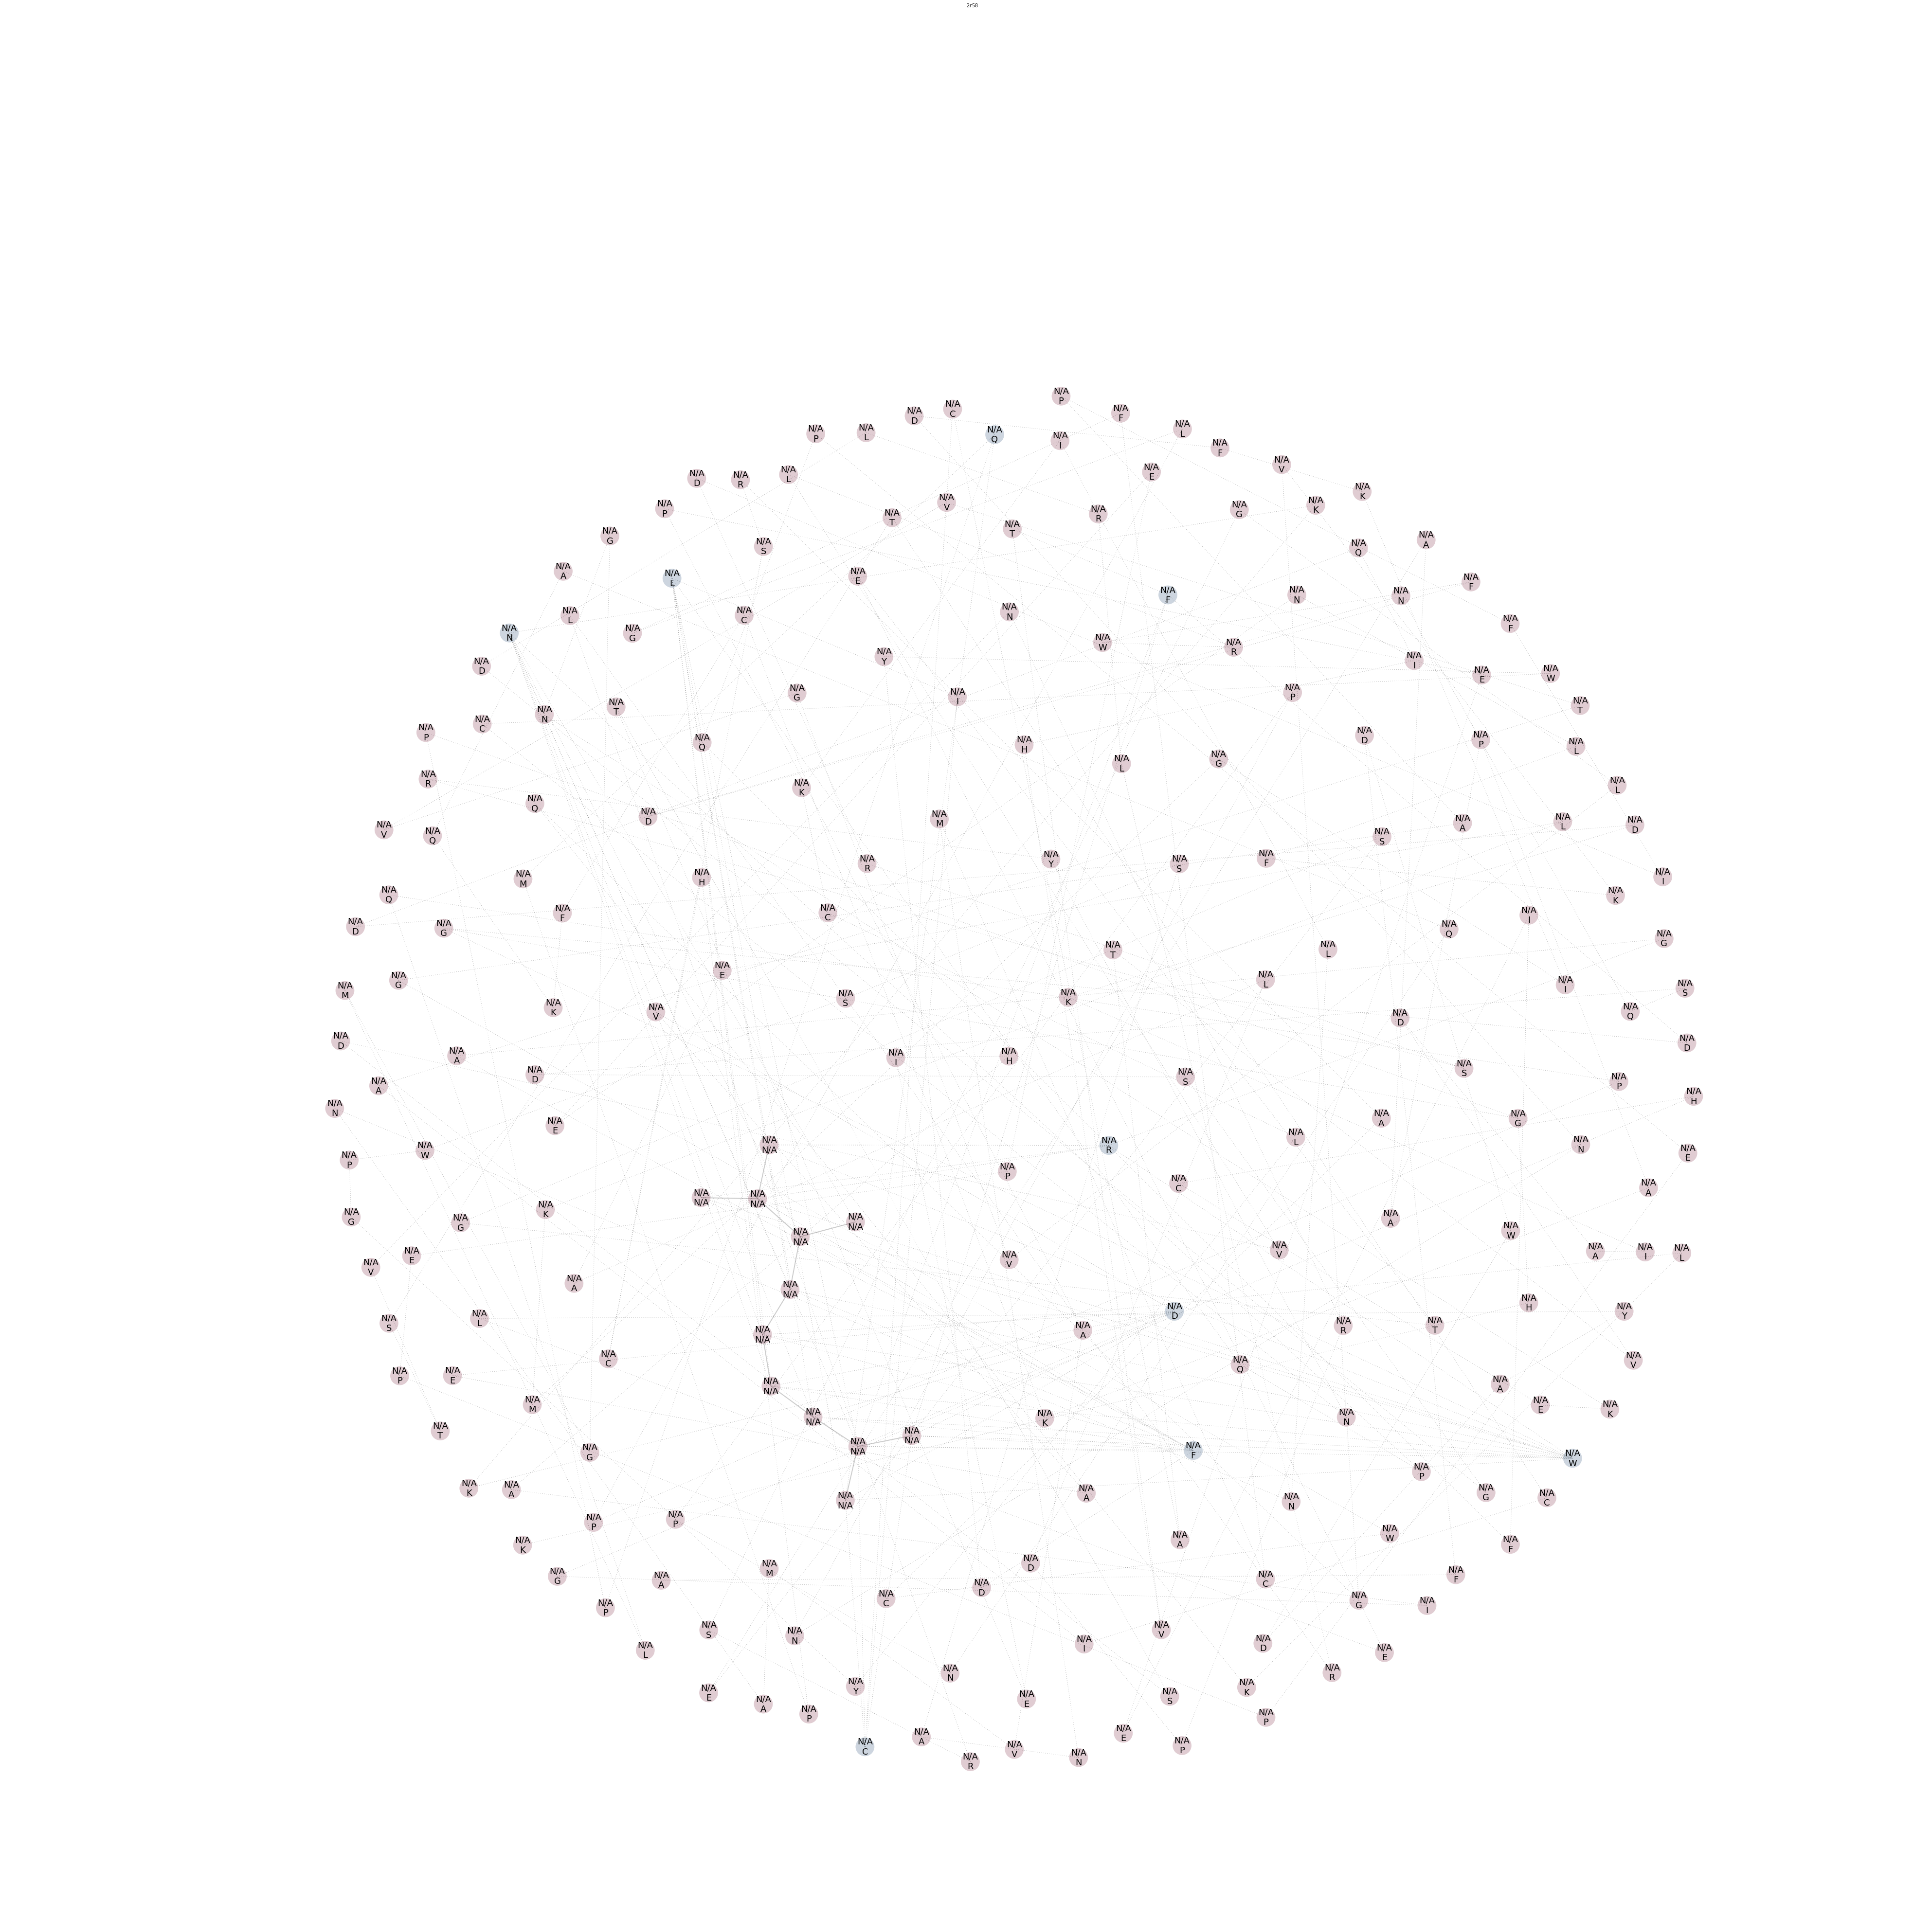

CPU times: user 7.15 s, sys: 183 ms, total: 7.34 s
Wall time: 7.58 s


In [15]:
%%time
from eden.util.display import draw_graph
display_params = dict(size=70, edge_label=None, vertex_label='label',
                      vertex_color='contact', secondary_vertex_label='name',
                      font_size=18,edge_alpha=.2,vertex_alpha=.2, colormap='RdBu', vertex_size=1500,
                      ignore_for_layout='nesting')

#for th in range(6,7):
#    print 'distance_threshold:', th
#    g = make_graph(structure, distance_threshold=8, distance_threshold2=th, scheme='code_3',ligand_marker='MLY')
#    draw_graph(g, **display_params)

#for g in graphs:
#    draw_graph(g, **display_params)
draw_graph(graphs[0], **display_params)
#draw_graph(graphs[1], **display_params)

In [ ]:
# EARLIER CODE: do not use yet!

from GArDen.interfaces import convert, transform
#from GArDen.transform.node import AddNodeAttributeValue
#from GArDen.transform import DeleteNode
#from GArDen.transform.trim_to_largest_component import TrimToLargestComponent
from eden.graph import Vectorizer
from eden.util import vectorize
from sklearn.svm import SVR
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import StratifiedKFold
import time

def run_experiment(data_fname='interaction_data', 
                   #target_fname = 'PDBbind_refined07-core07.txt', 
                   max_depth=1, 
                   complexity=5,
                   C=100,
                   gamma=0.1,
                   n_iter=5):    
    #graphs = convert(data_fname, program=ConvertProteinLigand())
    #parameters_priors = dict(attribute='active', value=False)
    #graphs = transform(graphs, program=AddNodeAttributeValue(), parameters_priors=parameters_priors)
    #parameters_priors = dict(max_depth=max_depth, attribute='active')
    graphs = transform(graphs, program=MarkActive(), parameters_priors=parameters_priors)
    parameters_priors = dict(attribute_value_dict=[dict(active=False, type='protein')])
    graphs = transform(graphs, program=DeleteNode(), parameters_priors=parameters_priors)
    graphs = transform(graphs, program=TrimToLargestComponent())
    graphs = list(graphs)
    X = vectorize(graphs, vectorizer=Vectorizer(complexity=complexity), fit_flag=False, n_jobs=-1)
    y = make_target(target_fname, graphs)
    
    corr_list=[]
    for i in range(n_iter):
        predictor = SVR(C=C, gamma=gamma)
        predicted = cross_val_predict(predictor, X, y, cv=StratifiedKFold(y, n_folds=5, shuffle=True, random_state=int(time.time())), n_jobs=-1)
        corr = np.corrcoef([predicted,y])[0][1]
        corr_list.append(corr)
    return np.mean(corr_list), np.std(corr_list)

In [ ]:
from eden.util.display import draw_graph_set
from GArDen.transform.node import ColorNode
parameters_priors = dict(output_attribute='level', labels=[['C','O','N','S','H','Cl','.C','.O','.N','.S','.H','.Cl']])
draw_graphs = transform(graphs, program=ColorNode(), parameters_priors=parameters_priors)
draw_graph_set(draw_graphs, n_graphs_per_line=2, size=20, title_key='id', prog='sfdp', colormap='Set3',
               edge_color='_label_',vertex_alpha=1, edge_alpha=.4, vertex_label='label', #secondary_vertex_label='type', 
               vertex_color='level', ignore_for_layout='nesting')